Fraud Card Transaction 

card_transdata.csv dataset has 1,000,000 rows and 8 columns:
https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud/data


In [15]:
#packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [21]:
df = pd.read_csv("card_transdata.csv")

binaryCol = ['repeat_retailer', 'used_chip', 'used_pin_number', 'online_order', 'fraud']
df[binaryCol] = df[binaryCol].astype('int8')
df.drop_duplicates(inplace=True)

train_df, test_df = train_test_split(df, 
                                     train_size=0.8, 
                                     random_state=42, 
                                     stratify=df['fraud'])

y_train = train_df['fraud']
X_train = train_df.drop(['fraud'], axis=1)
y_test = test_df['fraud']
X_test = test_df.drop(['fraud'], axis=1)

contCol = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']
binaryCol = ['repeat_retailer', 'used_chip', 'used_pin_number', 'online_order']

s = StandardScaler()
X_train_scaled_cont = s.fit_transform(X_train[contCol])
X_test_scaled_cont = s.transform(X_test[contCol])

X_train_scaled = pd.DataFrame(X_train_scaled_cont, columns=contCol, index=X_train.index)
X_train_scaled[binaryCol] = X_train[binaryCol]
X_train_scaled = X_train_scaled[X_train.columns]

X_test_scaled = pd.DataFrame(X_test_scaled_cont, columns=contCol, index=X_test.index)
X_test_scaled[binaryCol] = X_test[binaryCol]
X_test_scaled = X_test_scaled[X_test.columns]

#model training
lr = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr.fit(X_train_scaled, y_train)

svc = SVC(kernel='linear', random_state=42, class_weight='balanced', max_iter=2000)
svc.fit(X_train_scaled, y_train)

yLr = lr.predict(X_test_scaled)
print("\nLogistic Regression:")
print(classification_report(y_test, yLr, target_names=['Not Fraud (0)', 'Fraud (1)']))

ySvc = svc.predict(X_test_scaled)
print("\nSVM (SVC:")
print(classification_report(y_test, ySvc, target_names=['Not Fraud (0)', 'Fraud (1)']))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(



Logistic Regression:
               precision    recall  f1-score   support

Not Fraud (0)       0.99      0.93      0.96    182519
    Fraud (1)       0.58      0.95      0.72     17481

     accuracy                           0.93    200000
    macro avg       0.79      0.94      0.84    200000
 weighted avg       0.96      0.93      0.94    200000


SVM (SVC:
               precision    recall  f1-score   support

Not Fraud (0)       0.99      0.10      0.19    182519
    Fraud (1)       0.10      0.99      0.17     17481

     accuracy                           0.18    200000
    macro avg       0.54      0.55      0.18    200000
 weighted avg       0.91      0.18      0.19    200000




CONFUSION MATRIX VALUES

Logistic Regression Confusion Matrix:
True Negatives (TN):  170377
False Positives (FP): 12142
False Negatives (FN): 909
True Positives (TP):  16572

SVM Confusion Matrix:
True Negatives (TN):  18755
False Positives (FP): 163764
False Negatives (FN): 139
True Positives (TP):  17342


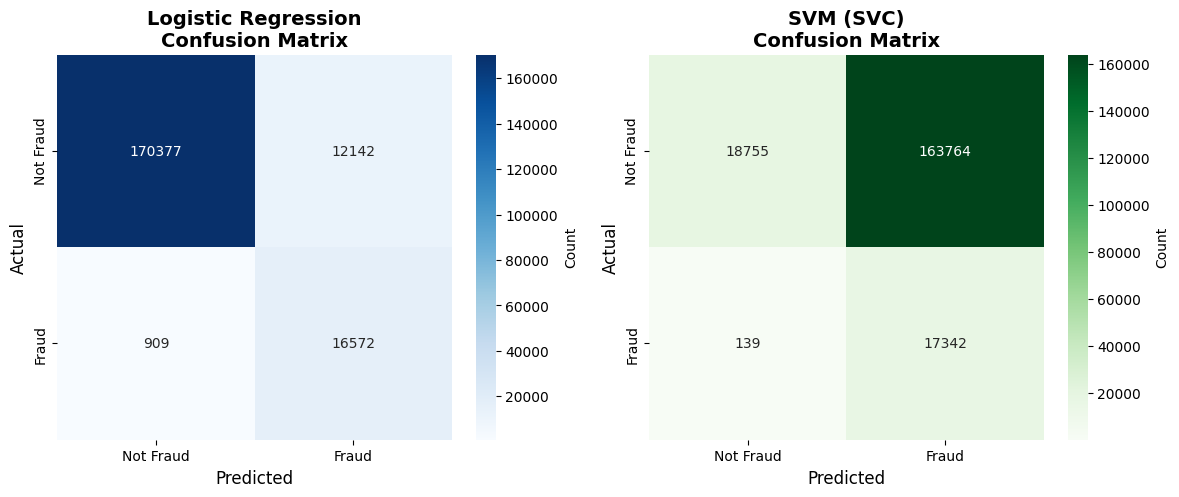

In [22]:
#confusion matrix
cm_lr = confusion_matrix(y_test, yLr)
cm_svc = confusion_matrix(y_test, ySvc)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            cbar_kws={'label': 'Count'})
axes[0].set_title('Logistic Regression\nConfusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Actual', fontsize=12)
axes[0].set_xlabel('Predicted', fontsize=12)

# SVM Confusion Matrix
sns.heatmap(cm_svc, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            cbar_kws={'label': 'Count'})
axes[1].set_title('SVM (SVC)\nConfusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Actual', fontsize=12)
axes[1].set_xlabel('Predicted', fontsize=12)
print("\n" + "="*50)
print("CONFUSION MATRIX VALUES")
print("="*50)

print("\nLogistic Regression Confusion Matrix:")
print(f"True Negatives (TN):  {cm_lr[0, 0]}")
print(f"False Positives (FP): {cm_lr[0, 1]}")
print(f"False Negatives (FN): {cm_lr[1, 0]}")
print(f"True Positives (TP):  {cm_lr[1, 1]}")

print("\nSVM Confusion Matrix:")
print(f"True Negatives (TN):  {cm_svc[0, 0]}")
print(f"False Positives (FP): {cm_svc[0, 1]}")
print(f"False Negatives (FN): {cm_svc[1, 0]}")
print(f"True Positives (TP):  {cm_svc[1, 1]}")
